In [1]:
from warnings import filterwarnings
import time
import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, matthews_corrcoef, roc_auc_score, make_scorer
import matplotlib.pyplot as plt
from teachopencadd.utils import seed_everything
# Silence some expected warnings
filterwarnings("ignore")
# Fix seed for reproducible results
SEED = 0
seed_everything(SEED)
data =  pd.read_csv("E:/mt-dnn/csv/init_ECFP.csv",index_col=[0])

In [2]:
X = [np.array(data.iloc[i,:1024]) for i in range(len(data["L858R/T790M/C797S"])) if data["L858R/T790M/C797S"][i] != -1]
Y = [data["L858R/T790M/C797S"][i] for i in range(len(data["L858R/T790M/C797S"])) if data["L858R/T790M/C797S"][i] != -1]
Y = np.round(Y)
fingerprint_len = len(X[0])
sample = data.columns[0]

1384 1024 1384


In [3]:
static_train_x = np.array(X)
static_train_y = np.array(Y)

data2 =  pd.read_csv("E:/mt-dnn/csv/test_ECFP.csv",index_col=[0])
X2 = [np.array(data2.iloc[i,:1024]) for i in range(len(data2["L858R/T790M/C797S"]))]
Y2 = data2["L858R/T790M/C797S"].tolist()
Y2 = np.round(Y2)

static_test_x = np.array(X2)
static_test_y = np.array(Y2)

splits= [static_train_x, static_test_x, static_train_y, static_test_y]
print(len(static_train_x),len(static_test_x))

1384 304


In [4]:
def tanimoto(x, y):
  common = [x[i] for i in range(len(x)) if y[i] == x[i]]
  return float(len(common))/(len(x) + len(y) - len(common))
def pearson(x,y):
  x = np.array(x)
  y = np.array(y)
  return np.corrcoef(x, y)[0][1]
def similarity(df, feature1, feature2):
  featurelist1 = df[feature1].tolist()
  featurelist2 = df[feature2].tolist()
  if sample[-2].upper() == "S":
    return abs(pearson(featurelist1,featurelist2))
  else:
    return abs(tanimoto(featurelist1,featurelist2)-0.5)


In [5]:
# make two dataframes for train and test set
data_train = pd.DataFrame(static_train_x)
data_train.columns = [f"{sample[:-1]}{i+1}" for i in range(fingerprint_len)]
data_train["L858R/T790M/C797S"] =  static_train_y
data_test = pd.DataFrame(static_test_x)
data_test.columns = [f"{sample[:-1]}{i+1}" for i in range(fingerprint_len)]
data_test["L858R/T790M/C797S"] =  static_test_y

In [7]:
# preprocessing
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler().fit(static_train_x)
static_test_x = scaler.transform(static_test_x) *0.8+0.1
static_train_x = scaler.transform(static_train_x) *0.8+0.1
# correlation with activity
for i in range(fingerprint_len):
  query = f"{sample[:-1]}{i+1}"
  if query in data_train.columns:
    print(similarity(data_train,query,"L858R/T790M/C797S"),end=",")

0.02373333333333333,0.060582423296931864,0.028442317916002102,0.026091586794462218,0.10272589601211507,0.026091586794462218,0.018994114499732484,0.02215696743192741,0.07246003094378545,0.01422319474835887,0.042390731964191686,0.02215696743192741,0.030005310674455665,0.05456919060052218,0.060582423296931864,0.18503562945368168,0.025306339904102304,0.02373333333333333,0.02294557097118466,0.04008438818565402,0.04085397996837109,0.03699788583509511,0.026091586794462218,0.03234358430540829,0.026091586794462218,0.05758207399687337,0.03699788583509511,0.021367521367521347,0.02294557097118466,0.010226049515608182,0.020577231427044373,0.07686375321336764,0.041622760800842984,0.2035128805620609,0.043924250394529185,0.043924250394529185,0.0797845048742945,0.03544973544973545,0.04468980021030494,0.011827956989247324,0.020577231427044373,0.059833506763787736,0.05758207399687337,0.020577231427044373,0.026091586794462218,0.011027434104357192,0.04926624737945495,0.006206152185644909,0.0229455709711846

In [8]:
print(data.shape,data_train.shape,data_test.shape)
X = [np.array(data.iloc[i,:data.shape[1]-1]) for i in range(data.shape[0])]
Y = data["L858R/T790M/C797S"].tolist()
static_train_x = [np.array(data_train.iloc[i,:data_train.shape[1]-1]) for i in range(data_train.shape[0])]
static_train_y = data_train["L858R/T790M/C797S"].tolist()
static_test_x = [np.array(data_test.iloc[i,:data_test.shape[1]-1]) for i in range(data_test.shape[0])]
static_test_y = data_test["L858R/T790M/C797S"].tolist()
print(len(X),len(X[0]),len(static_train_x),len(static_train_x[0]),len(static_test_x),len(static_test_x[0]))
splits= [static_train_x, static_test_x, static_train_y, static_test_y]
X = np.vstack((static_train_x,static_test_x)).tolist()
Y = static_train_y + static_test_y

(2302, 1029) (1384, 1025) (304, 1025)
2302 1028 1384 1024 304 1024


In [11]:
def plot_roc_curves_for_models(models, splits, save_png=False):
    train_x, test_x, train_y, test_y = splits
    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        train_prob = ml_model.predict_proba(train_x)[:, 1]
        # Compute False postive rate and True positive rate
        fpr_, tpr_, thresholds_ = metrics.roc_curve(train_y, train_prob)
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc_ = roc_auc_score(train_y, train_prob)
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr_, tpr_, label=(f"{model['label']}_train_AUC_area = {auc_:.2f}"))
        ax.plot(fpr, tpr, label=(f"{model['label']}_test_AUC_area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"E://roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

In [12]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)
    # Performance of model on test set
    accuracy = balanced_accuracy_score(test_y, test_pred)
    precision = precision_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)
    mcc = matthews_corrcoef(test_y, test_pred)


    print()
    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"matthews_corrcoef: {mcc:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, precision, sens, spec, mcc, auc

In [13]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    if verbose:
        print("训练集：")
    accuracy_t, precision_t, sens_t, spec_t, mcc_t, auc_t = model_performance(ml_model, train_x, train_y, verbose)
    if verbose:
        print("测试集：")
    accuracy, precision, sens, spec, mcc, auc = model_performance(ml_model, test_x, test_y, verbose)
    
    return accuracy, precision, sens, spec, mcc, auc

In [16]:
from QSAR_package.grid_search import gridSearchPlus
from QSAR_package.grid_search import gridSearchBase
svm_grid = gridSearchPlus(grid_estimatorName='SVC', fold=5, repeat=5)
svm_grid.Fit(data_train.iloc[:,:1024],static_train_y)
print(svm_grid.best_params)
print(len(svm_grid.best_features))

训练集数据shape:(1384, 1024)
第1/5次gridsearch，此轮耗时00h:19m:47s
训练集数据shape:(1384, 1024)
第2/5次gridsearch，此轮耗时00h:10m:29s
训练集数据shape:(1384, 1024)
第3/5次gridsearch，此轮耗时00h:10m:27s
训练集数据shape:(1384, 1024)
第4/5次gridsearch，此轮耗时00h:10m:02s
训练集数据shape:(1384, 1024)
第5/5次gridsearch，此轮耗时00h:09m:59s
5次gridsearch执行完毕，总耗时01h:00m:47s，可通过best_params属性查看最优参数，通过cv_results属性查看所有结果
{'C': 2, 'gamma': 0.03125}
1024


In [42]:
# 5 times for 5 clusters
data3 =  pd.read_csv("E:/mt-dnn/cluster0/init_ECFP.csv",index_col=[0])
data3.reset_index(drop=True, inplace=True) 
X = [np.array(data3.iloc[i,:1024]) for i in range(len(data3["L858R/T790M/C797S"])) if data3["L858R/T790M/C797S"][i] != -1]
Y = [data3["L858R/T790M/C797S"][i] for i in range(len(data3["L858R/T790M/C797S"])) if data3["L858R/T790M/C797S"][i] != -1]
Y = np.round(Y)
static_train_x = np.array(X)
static_train_y = np.array(Y)
splits= [static_train_x, static_test_x, static_train_y, static_test_y]
param = {**svm_grid.best_params, "probability" :True, "random_state" : SEED}
model_SVM = SVC(**param)
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

训练集：

Accuracy: 0.99
Precision: 0.99
Sensitivity: 0.99
Specificity: 0.99
matthews_corrcoef: 0.98
AUC: 1.00
测试集：

Accuracy: 0.59
Precision: 0.88
Sensitivity: 0.24
Specificity: 0.95
matthews_corrcoef: 0.24
AUC: 0.68


In [34]:
# recor hypermeter
models = []

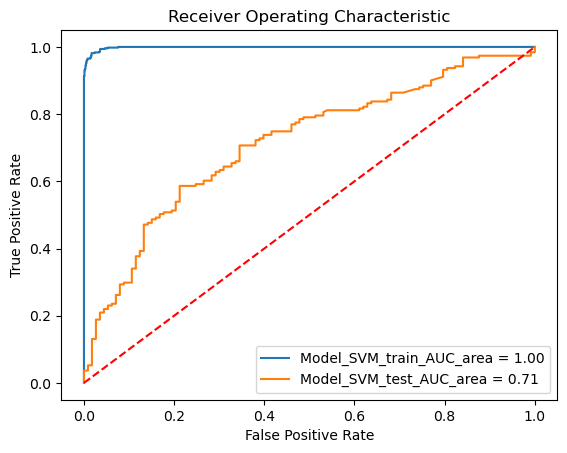

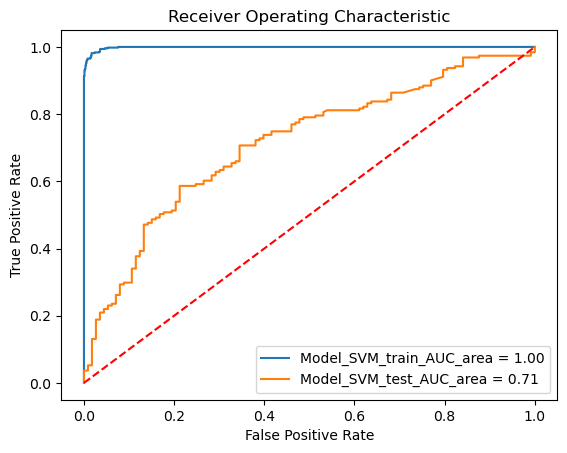

In [36]:
models.append({"label": "Model_SVM", "model": model_SVM})
roc =  [{"label": "Model_SVM", "model": model_SVM}]
plot_roc_curves_for_models(roc, splits)

In [18]:
from QSAR_package.grid_search import gridSearchPlus
from QSAR_package.grid_search import gridSearchBase
rf_grid = gridSearchPlus(grid_estimatorName='RFC', fold=5, repeat=5)
rf_grid.Fit(data_train.iloc[:, :1024],static_train_y)
print(rf_grid.best_params)
print(len(rf_grid.best_features))

训练集数据shape:(1384, 1024)
第1/5次gridsearch，此轮耗时00h:03m:14s
训练集数据shape:(1384, 1024)
第2/5次gridsearch，此轮耗时00h:01m:47s
训练集数据shape:(1384, 1024)
第3/5次gridsearch，此轮耗时00h:01m:51s
训练集数据shape:(1384, 1024)
第4/5次gridsearch，此轮耗时00h:02m:00s
训练集数据shape:(1384, 1024)
第5/5次gridsearch，此轮耗时00h:02m:03s
5次gridsearch执行完毕，总耗时00h:10m:57s，可通过best_params属性查看最优参数，通过cv_results属性查看所有结果
{'max_leaf_nodes': 50, 'n_estimators': 75}
1024


In [32]:
# 5 times for 5 clusters
data3 =  pd.read_csv("E:/mt-dnn/cluster0/init_ECFP.csv",index_col=[0])
data3.reset_index(drop=True, inplace=True) 
X = [np.array(data3.iloc[i,:1024]) for i in range(len(data3["L858R/T790M/C797S"])) if data3["L858R/T790M/C797S"][i] != -1]
Y = [data3["L858R/T790M/C797S"][i] for i in range(len(data3["L858R/T790M/C797S"])) if data3["L858R/T790M/C797S"][i] != -1]
Y = np.round(Y)
static_train_x = np.array(X)
static_train_y = np.array(Y)
splits= [static_train_x, static_test_x, static_train_y, static_test_y]
param = {**rf_grid.best_params,'random_state':SEED}
model_RF = RandomForestClassifier(**param)
performance_measures = model_training_and_validation(model_RF, "RF", splits)

训练集：

Accuracy: 1.00
Precision: 1.00
Sensitivity: 1.00
Specificity: 1.00
matthews_corrcoef: 1.00
AUC: 1.00
测试集：

Accuracy: 0.63
Precision: 0.87
Sensitivity: 0.36
Specificity: 0.91
matthews_corrcoef: 0.30
AUC: 0.68


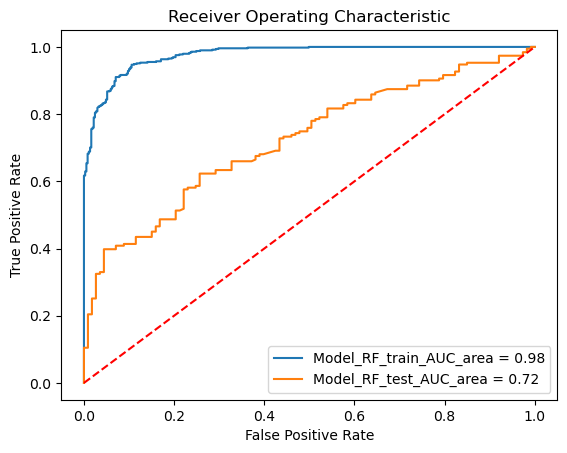

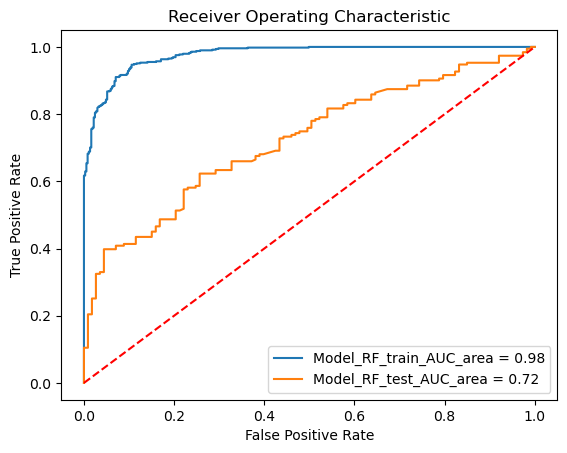

In [19]:
models.append({"label": "Model_RF", "model": model_RF})
roc =  [{"label": "Model_RF", "model": model_RF}]
plot_roc_curves_for_models(roc, splits)

In [14]:
from QSAR_package.grid_search import gridSearchPlus
from QSAR_package.grid_search import gridSearchBase
xgb_grid = gridSearchPlus(grid_estimatorName='XGBC', fold=5, repeat=5)
xgb_grid.Fit(data_train.iloc[:,:1024],static_train_y)
print(xgb_grid.best_params)
print(len(xgb_grid.best_features))

训练集数据shape:(1384, 1024)
第1/5次gridsearch，此轮耗时05h:32m:19s
训练集数据shape:(1384, 1024)
第2/5次gridsearch，此轮耗时02h:44m:05s
训练集数据shape:(1384, 1024)
第3/5次gridsearch，此轮耗时02h:39m:45s
训练集数据shape:(1384, 1024)
第4/5次gridsearch，此轮耗时02h:37m:23s
训练集数据shape:(1384, 1024)
第5/5次gridsearch，此轮耗时02h:36m:52s
5次gridsearch执行完毕，总耗时16h:10m:30s，可通过best_params属性查看最优参数，通过cv_results属性查看所有结果
{'gamma': 0.0009765625, 'learning_rate': 0.5, 'n_estimators': 85}
1024


In [20]:
# 5 times for 5 clusters
data3 =  pd.read_csv("E:/mt-dnn/cluster0/init_ECFP.csv",index_col=[0])
data3.reset_index(drop=True, inplace=True) 
X = [np.array(data3.iloc[i,:1024]) for i in range(len(data3["L858R/T790M/C797S"])) if data3["L858R/T790M/C797S"][i] != -1]
Y = [data3["L858R/T790M/C797S"][i] for i in range(len(data3["L858R/T790M/C797S"])) if data3["L858R/T790M/C797S"][i] != -1]
Y = np.round(Y)
static_train_x = np.array(X)
static_train_y = np.array(Y)
splits= [static_train_x, static_test_x, static_train_y, static_test_y]
param = {**xgb_grid.best_params,'random_state':SEED}
model_XGB = XGBClassifier(**param)
performance_measures = model_training_and_validation(model_XGB, "XGB", splits)

训练集：

Accuracy: 1.00
Precision: 1.00
Sensitivity: 1.00
Specificity: 1.00
matthews_corrcoef: 1.00
AUC: 1.00
测试集：

Accuracy: 0.55
Precision: 0.69
Sensitivity: 0.45
Specificity: 0.65
matthews_corrcoef: 0.10
AUC: 0.56


In [ ]:
models.append({"label": "Model_XGB", "model": model_XGB})
roc =  [{"label": "Model_XGB", "model": model_XGB}]
plot_roc_curves_for_models(roc, splits)